In [1]:
from pandas_datareader import data as pdr
import datetime
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
portfolio = ["SPYG", "SPY", "QQQ", "TQQQ"]
portfolio_ratio = [0.25, 0.25, 0.25, 0.25]
portfolio_seed = 100000
test_years = 40
rebalancing = True
rebalancing_bandwidth = 0.1
rebalancing_target_index = 3
start_day = datetime.datetime.now()-datetime.timedelta(days=int(365*test_years))  # 5년치

portfolio_holdings = []
market_index = pdr.get_data_yahoo("^GSPC", start_day)  # S&P 500
for ticker in portfolio:
    portfolio_holdings.append(pdr.get_data_yahoo(ticker, start_day))

In [3]:
# 테스트 기간을 전체 종목 중 최소 기간에 맞춤
def set_period(market_index, portfolio_holdings):
    print("입력 시작 기간 :", market_index.reset_index()["Date"][0])
    min_length = len(market_index)

    for i in range(len(portfolio_holdings)):
        if min_length > len(portfolio_holdings[i]):
            min_length = len(portfolio_holdings[i])

    min_length = min([df.shape[0] for df in portfolio_holdings])
    market_index = market_index[len(market_index)-min_length:]

    portfolio_holdings = [df[len(df)-min_length:] for df in portfolio_holdings]
    print("포트폴리오 시작일 :", market_index.reset_index()["Date"][0])

    return market_index, portfolio_holdings

market_index, portfolio_holdings = set_period(market_index, portfolio_holdings)

입력 시작 기간 : 1982-09-07 00:00:00
포트폴리오 시작일 : 2010-02-11 00:00:00


In [4]:
market_index["recent_high"] = market_index["Adj Close"].cummax()
market_index["dd"] = (1 - market_index["Adj Close"]/market_index["recent_high"]) * 100
market_yield = market_index["Adj Close"][-1]/market_index["Adj Close"][0]

portfolio_df = portfolio_holdings[0].copy()
portfolio_df["seed"] = 0
portfolio_df["rebalancing"] = 0

def simulation(portfolio_holdings, market_index):
    # 주가 변화 시뮬레이션
    rebalanced_month = 0
    portfolio_holdings.append(market_index)

    # 전일 대비 변동률 계산
    portfolio_ratio.append(1)
    for i, df in enumerate(portfolio_holdings):
        df["change"] = df["Adj Close"].pct_change()+1
        df["seed"] = portfolio_seed*portfolio_ratio[i]


    # 주가 변화 계산
    for i in tqdm(range(1, len(market_index))):
        for df in portfolio_holdings:
            df["seed"][i] = df["seed"][i-1]*df["change"][i]

        # 리밸런싱
        df_ratio = portfolio_holdings[rebalancing_target_index]["seed"][i]/sum([df["seed"][i] for df in portfolio_holdings[:-1]])
        # 상방 밴드
        if df_ratio > portfolio_ratio[rebalancing_target_index]+rebalancing_bandwidth:
            portfolio_df["rebalancing"][i] = 1
            temp_seed = 0
            for df in portfolio_holdings[:-1]:
                temp_seed += df["seed"][i]*0.9975
            for j, df in enumerate(portfolio_holdings[:-1]):
                df["seed"][i] = temp_seed*portfolio_ratio[j]
        # 하방 밴드
        elif df_ratio < portfolio_ratio[rebalancing_target_index]-rebalancing_bandwidth:
            portfolio_df["rebalancing"][i] = 2
            temp_seed = 0
            for df in portfolio_holdings[:-1]:
                temp_seed += df["seed"][i]*0.9975
            for j, df in enumerate(portfolio_holdings[:-1]):
                df["seed"][i] = temp_seed*portfolio_ratio[j]

    return portfolio_holdings[:-1], portfolio_holdings[-1]

def print_analyze(name, df):
    def print_standard_analyze(name, df):
        print(f"종목명 : {name}")
        total_yield = df["seed"][-1]/df["seed"][0]
        print(f"최종금액 : {int(df['seed'][-1])}원")
        print(f"총 수익률 : {round((total_yield-1)*100, 2)}%")
        print(f"연평균 수익률 : {round((total_yield ** (1/test_years)-1) * 100, 2)}%")

        df["recent_high"] = df["seed"].cummax()
        df["dd"] = (1 - df["seed"]/df["recent_high"]) * 100
        print(f"최대 낙폭(MDD) : {round(df['dd'].max(), 2)}%\n")

        return total_yield

    if name != "포트폴리오":
        print_standard_analyze(name, df)
        global portfolio_df
        portfolio_df["seed"] += df["seed"]

    else:
        portfolio_yield = print_standard_analyze("포트폴리오", df)

        print(f"포트폴리오의 최초 금액은 {portfolio_seed}원, 최종 금액은 {int(df['seed'][-1])}원으로 최종 수익률은 {round((portfolio_yield-1)*100, 2)}% 입니다.\n"
              f"같은 기간 동안 시장의 수익률은 {round((market_yield-1)*100, 2)}%로 시장{'을 이겼습니다.' if portfolio_yield>market_yield else '에 졌습니다.'}\n"
              f"최대 낙폭은 {round(df['dd'].max(), 2)}로 같은 기간 시장 최대 낙폭 {round(market_index['dd'].max(), 2)}보다 더 {'높아 위험합니다.' if df['dd'].max() > market_index['dd'].max() else '낮아 안정적입니다.'}")

        print()

In [5]:
portfolio_holdings, market_index = simulation(portfolio_holdings, market_index)

for index, df in enumerate(portfolio_holdings):
    print_analyze(portfolio[index], df)

print_analyze("포트폴리오", portfolio_df)


100%|██████████| 3157/3157 [00:01<00:00, 2977.84it/s]

종목명 : SPYG
최종금액 : 325887원
총 수익률 : 1203.55%
연평균 수익률 : 6.63%
최대 낙폭(MDD) : 39.33%

종목명 : SPY
최종금액 : 313905원
총 수익률 : 1155.62%
연평균 수익률 : 6.53%
최대 낙폭(MDD) : 37.58%

종목명 : QQQ
최종금액 : 323845원
총 수익률 : 1195.38%
연평균 수익률 : 6.61%
최대 낙폭(MDD) : 36.65%

종목명 : TQQQ
최종금액 : 390377원
총 수익률 : 1461.51%
연평균 수익률 : 7.11%
최대 낙폭(MDD) : 70.74%

종목명 : 포트폴리오
최종금액 : 1354015원
총 수익률 : 1254.02%
연평균 수익률 : 6.73%
최대 낙폭(MDD) : 43.71%

포트폴리오의 최초 금액은 100000원, 최종 금액은 1354015원으로 최종 수익률은 1254.02% 입니다.
같은 기간 동안 시장의 수익률은 280.99%로 시장을 이겼습니다.
최대 낙폭은 43.71로 같은 기간 시장 최대 낙폭 33.92보다 더 높아 위험합니다.



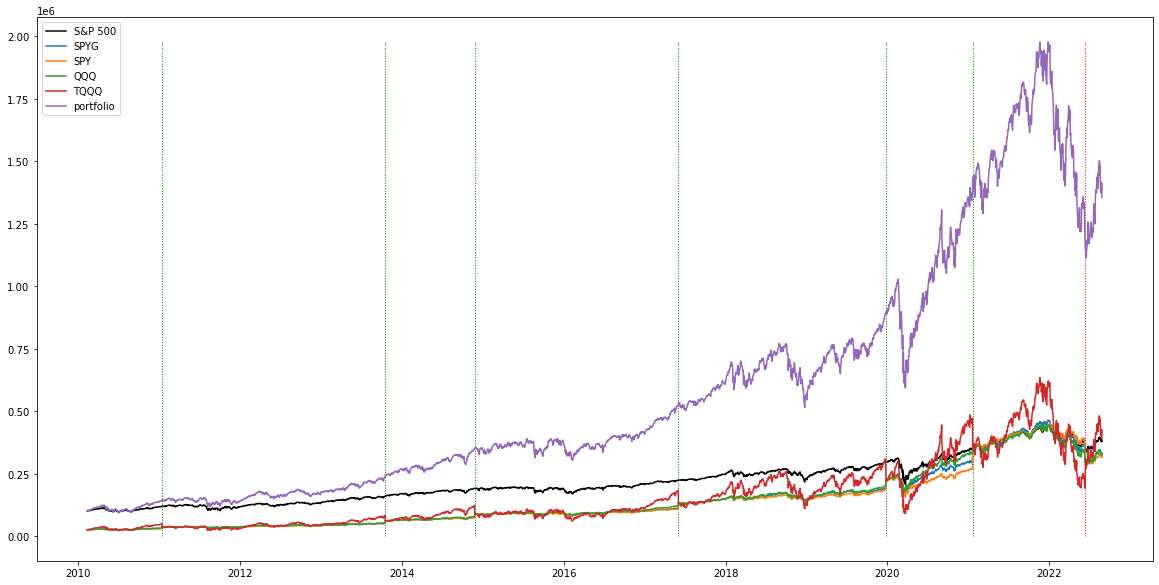

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(market_index["seed"], label="S&P 500", color="black")
for i, df in enumerate(portfolio_holdings):
    plt.plot(df["seed"], label=portfolio[i])

plt.vlines(portfolio_df[portfolio_df["rebalancing"]==1].index, ymin=0, ymax=portfolio_df["seed"].max(), linewidth=1, linestyles="dotted", color="green")
plt.vlines(portfolio_df[portfolio_df["rebalancing"]==2].index, ymin=0, ymax=portfolio_df["seed"].max(), linewidth=1, linestyles="dotted", color="red")
plt.plot(portfolio_df["seed"], label="portfolio")
plt.legend()